#### some libraries for lab computers

!pip install torch -U

!pip install torch torchvision torchaudio --user --index-url https://download.pytorch.org/whl/cu117

!pip install torch torchvision

!pip install transformers==4.38.2

-------------------

In [1]:
#importing relevant libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns

In [2]:
#specifying column names
column_names=['label','sentence']

In [3]:
#reading train data
train_df=pd.read_csv("propaganda_train.tsv",delimiter="\t",quotechar='|')
train_df.columns=column_names
train_df.head()

,label,sentence
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,"""The Obama administration misled the <BOS> Ame..."
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


In [4]:
#reading validation data
val_df=pd.read_csv("propaganda_val.tsv",delimiter="\t",quotechar='|')
val_df.columns=column_names
val_df.head()

,label,sentence
0,not_propaganda,"On average, between 300 and 600 infections are..."
1,causal_oversimplification,Mostly because <BOS> the country would not las...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.
4,repetition,It must be exacted from him directly in order ...


In [5]:
#to check whether there is a different class which has train or validation, while it doesn't exist in the other one
alist=[]
for (label_train,label_val) in zip(train_df['label'].unique(),val_df['label'].unique()):
    if label_train not in val_df['label'].unique():
        alist.append(label_train)
    elif label_val not in train_df['label'].unique():
        alist.append(label_val)
if len(alist)!=0:
    print('There are {} propaganda types which don\'t exist in both'.format(len(alist_tr)))
elif len(alist)==0:
    print('There is no propaganda type which doesn\'t exist in both')

There is no propaganda type which doesn't exist in both


In [6]:
#number of labels in train data
train_df.label.value_counts()

label
not_propaganda               1269
exaggeration,minimisation     170
name_calling,labeling         166
causal_oversimplification     165
loaded_language               161
repetition                    160
doubt                         157
appeal_to_fear_prejudice      157
flag_waving                   155
Name: count, dtype: int64

In [7]:
#number of labels in validation data
val_df.label.value_counts()

label
not_propaganda               331
flag_waving                   45
appeal_to_fear_prejudice      43
doubt                         43
repetition                    40
loaded_language               39
causal_oversimplification     35
name_calling,labeling         34
exaggeration,minimisation     30
Name: count, dtype: int64

In [8]:
#train data info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2560 entries, 0 to 2559
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     2560 non-null   object
 1   sentence  2560 non-null   object
dtypes: object(2)
memory usage: 40.1+ KB


In [9]:
#validation data info
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     640 non-null    object
 1   sentence  640 non-null    object
dtypes: object(2)
memory usage: 10.1+ KB


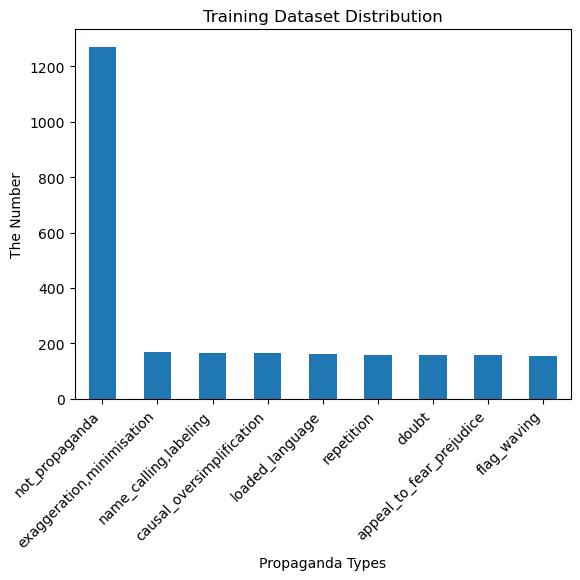

In [10]:
#train data label distribution
train_df.label.value_counts().plot(kind='bar')
plt.title('Training Dataset Distribution')
plt.xlabel('Propaganda Types')
plt.ylabel('The Number')
plt.xticks(rotation=45, ha="right")
plt.show()

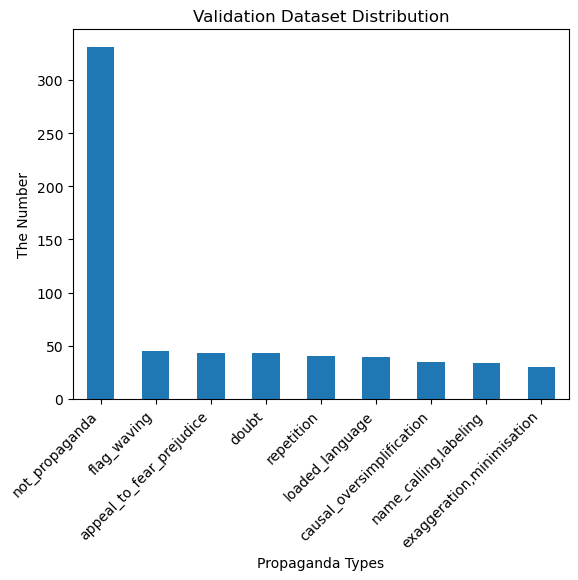

In [11]:
#validation data label distribution
val_df.label.value_counts().plot(kind='bar')
plt.title('Validation Dataset Distribution')
plt.xlabel('Propaganda Types')
plt.ylabel('The Number')
plt.xticks(rotation=45, ha="right")
plt.show()

# Task1: Propaganda Detection

In [12]:
#copying dataframes to keep the actual data save
train_df2=train_df.copy(deep=True)
val_df2=val_df.copy(deep=True)

## Changing Propaganda Types with "Propaganda" Label

Since we want to find whether a sentence contains propaganda, we need to change the propaganda types with "propaganda" label.

In [13]:
#change propaganda types as propaganda
train_df2['label']=train_df2['label'].apply(lambda x: x if x=='not_propaganda' else 'propaganda')
val_df2['label']=val_df2['label'].apply(lambda x: x if x=='not_propaganda' else 'propaganda')
train_df2.head()

,label,sentence
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,propaganda,"""The Obama administration misled the <BOS> Ame..."
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


## Removing BOS and EOS Tags

Normally, we can't see any tag, when we find the data from a source such as social media. The tags **< BOS >** and **< EOS >** should be removed from each sentence.

In [14]:
#replace the tags with empty character in trainin data
train_df2['sentence']=train_df2['sentence'].apply(lambda x: x.replace("<BOS>","").replace("<EOS>","").replace("  "," "))

In [15]:
#display training data to be sure last changes
train_df2.head()

,label,sentence
0,not_propaganda,"No, he will not be confirmed."
1,not_propaganda,This declassification effort won’t make things...
2,propaganda,"""The Obama administration misled the American ..."
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"Location: Westerville, Ohio"


In [16]:
#replace the tags with empty character in validation data
val_df2['sentence']=val_df2['sentence'].apply(lambda x: x.replace("<BOS>","").replace("<EOS>","").replace("  "," "))

In [17]:
#display validation data to be sure last changes
val_df2.head()

,label,sentence
0,not_propaganda,"On average, between 300 and 600 infections are..."
1,propaganda,Mostly because the country would not last long...
2,propaganda,Lyndon Johnson gets Earl Warren and Sen. Richa...
3,not_propaganda,You may opt out at anytime.
4,propaganda,It must be exacted from him directly in order ...


In [18]:
#creating 2 dictionaries:
#labels: labels are as key, 0 and 1 are as value. Each label has a unique number
#reverse_index: reverse version of labels
labels={}
reverse_index={}
for i,j in enumerate(train_df2.label.unique()):
    labels[j]=i
    reverse_index[i]=j
labels

{'not_propaganda': 0, 'propaganda': 1}

In [19]:
#display reverse index dictionary to check
#reverse_index={i:label for i,label in enumerate(labels)}   #another method to create reverse index
reverse_index

{0: 'not_propaganda', 1: 'propaganda'}

## **Hyperparameters:**

**epochs:** [1,5,10]

**batch_size:** [2,4,8,16,32,64]

**Learning Rate:** [1e-6, 1e-4, 1e-2]

**freeze and unfreeze the model weights:** model.bert.requires_grad_(False) **or** model.bert.requires_grad_(True)

**Bert Model (large/base):** google-bert/bert-large-uncased **or** bert-base-uncased



In [20]:
#import required libraries
import torch
import numpy as np
import time
#import Bert tokenizer and model from Huggingface
from transformers import BertTokenizer, BertModel

In [21]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self,df,text_column_name):
        self.labels=[labels[label] for label in df["label"]]
        self.texts=[tokenizer(text.lower(),padding='max_length',max_length=512,truncation=True,return_tensors="pt") for text in df[text_column_name]]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self,idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self,idx):
        return self.texts[idx]

    def __getitem__(self,idx):
        batch_texts=self.get_batch_texts(idx)
        batch_y=self.get_batch_labels(idx)

        return batch_texts,batch_y

In [22]:
#prepare inputs for GPU
def prepare_inputs(input1,label,device):
    label=label.to(device)
    mask=input1['attention_mask'].to(device)
    input_id=input1['input_ids'].squeeze(1).to(device)
    return (input_id,mask,label)

In [23]:
def bertModel(par="base"):
    if par=="base":
        return "bert-base-uncased"
    elif par=="large":
        return "google-bert/bert-large-uncased"

In [24]:
#now we need to put a simple classification layer on top of BERT


from torch import nn


class BertClassifier(nn.Module):

    def __init__(self,dropout=0.5,num_classes=2):

        super(BertClassifier,self).__init__()

        self.bert=BertModel.from_pretrained(bert_model)
        self.dropout=nn.Dropout(dropout)
        self.linear=nn.Linear(self.bert.config.hidden_size,num_classes)
        self.relu=nn.ReLU()

    def forward(self,input_id,mask):

        last_hidden_layer,pooled_output = self.bert(input_ids=input_id,attention_mask=mask,return_dict=False)
        dropout_output=self.dropout(pooled_output)
        linear_output=self.linear(dropout_output)
        final_layer=self.relu(linear_output)

        return final_layer

In [25]:
def get_labels_from_tensor(predictions):
    alist=[]
    for prediction_tensor in predictions:
        for prediction in prediction_tensor:
            alist.append(prediction.cpu().numpy().item())
    return alist

In [26]:
#we now need a training loop

from torch.optim import Adam
from tqdm import tqdm  #useful library to report on progress through an iteration


def train(model, train_data,val_data,list_numeric_val,learning_rate,epochs,batch_size):
    
    alist=[]
    
    starting=time.time()
    train_dataloader=torch.utils.data.DataLoader(train_data,batch_size,shuffle=True)
    val_dataloader=torch.utils.data.DataLoader(val_data,batch_size)

    use_cuda=torch.cuda.is_available()
    device=torch.device("cuda" if use_cuda else "cpu")

    criterion=nn.CrossEntropyLoss()
    optimizer=Adam(model.parameters(),lr=learning_rate)

    if use_cuda:
        model=model.cuda()
        criterion=criterion.cuda()

    for epoch_num in range(epochs):
        adict={}
        total_acc_train=0
        total_loss_train=0
        model.train()
        prediction_list_train=[]
        for train_input,train_label in tqdm(train_dataloader):

            input_id,mask, train_label=prepare_inputs(train_input,train_label,device)

            output=model(input_id,mask)

            batch_loss=criterion(output,train_label.long())
            total_loss_train +=batch_loss.item()

            acc=(output.argmax(dim=1)==train_label).sum().item()
        
            prediction_list_train.append(output.argmax(dim=1))
            total_acc_train+=acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val=0
        total_loss_val=0
        model.eval()
        prediction_list_val=[]
        with torch.no_grad():
            for val_input,val_label in val_dataloader:

                input_id,mask, val_label=prepare_inputs(val_input,val_label,device)

                output=model(input_id,mask)

                batch_loss=criterion(output,val_label.long())

                total_loss_val+=batch_loss.item()

                acc=(output.argmax(dim=1)==val_label).sum().item()
                
                total_acc_val+=acc
               
                prediction_list_val.append(output.argmax(dim=1))
                
      
                    
        ending=time.time()
        elapsed_time=ending-starting
        adict["epochs"]= epochs
        adict["train_loss"]= total_loss_train / len(train_data)
        adict["train_accuracy"]= total_acc_train/len(train_data)

        adict["val_loss"]= total_loss_val/len(val_data)
        adict["val_accuracy"]= total_acc_val / len(val_data)
        adict["time"]=elapsed_time
        
        adict["batch_size"]=batch_size
        adict["Bert Model"]=bert_model
        adict["learning rate"]=learning_rate
        
        prediction_list_val=get_labels_from_tensor(prediction_list_val)
        prediction_list_train=get_labels_from_tensor(prediction_list_train)
        
       #adict["accuracy"] = accuracy_score(list_numeric_val, prediction_list_val)
       #adict["f1"] = f1_score(list_numeric_val, prediction_list_val)
       #adict["precision"] = precision_score(list_numeric_val, prediction_list_val)
       #adict["recall"] = recall_score(list_numeric_val, prediction_list_val)
        
        alist.append(adict)
       
    return alist,prediction_list_train,prediction_list_val

In [27]:
use_cuda=torch.cuda.is_available()
device=torch.device("cuda" if use_cuda else "cpu")

In [28]:
from sklearn.metrics import classification_report

In [29]:
def freezeBERT(freeze=True):
    if freeze==True:
        par=False
    elif freeze==False:
        par=True
    return par    

In [30]:
def evaluate(model, train_data,val_data,list_numeric_val,learning_rate,epochs,batch_size):
    
    alist=[]
   
    train_dataloader=torch.utils.data.DataLoader(train_data,batch_size,shuffle=True)
    val_dataloader=torch.utils.data.DataLoader(val_data,batch_size)

    use_cuda=torch.cuda.is_available()
    device=torch.device("cuda" if use_cuda else "cpu")

    criterion=nn.CrossEntropyLoss()
    optimizer=Adam(model.parameters(),lr=learning_rate)

    if use_cuda:
        model=model.cuda()
        criterion=criterion.cuda()

    for epoch_num in range(epochs):
        adict={}
        total_acc_train=0
        total_loss_train=0
        
        prediction_list_train=[]

        total_acc_val=0
        total_loss_val=0
        model.eval()
        prediction_list_val=[]
        with torch.no_grad():
            for val_input,val_label in tqdm(val_dataloader):

                input_id,mask, val_label=prepare_inputs(val_input,val_label,device)

                output=model(input_id,mask)

                batch_loss=criterion(output,val_label.long())

                total_loss_val+=batch_loss.item()

                acc=(output.argmax(dim=1)==val_label).sum().item()
                
                total_acc_val+=acc
               
                prediction_list_val.append(output.argmax(dim=1))
                
      
                    
    
        adict["epochs"]= epoch_num
        adict["val_loss"]= total_loss_val/len(val_data)
        adict["val_accuracy"]= total_acc_val / len(val_data)
        
        
        prediction_list_val=get_labels_from_tensor(prediction_list_val)
        
        
        adict["accuracy"] = accuracy_score(list_numeric_val, prediction_list_val)
        adict["f1"] = f1_score(list_numeric_val, prediction_list_val, average='weighted')
        adict["precision"] = precision_score(list_numeric_val, prediction_list_val, average='weighted')
        adict["recall"] = recall_score(list_numeric_val, prediction_list_val, average='weighted')
        
        alist.append(adict)
       
    return alist,prediction_list_val

## Base BERT Model

## Freeze Model Weights (not good approach)

**epochs:** [1,5,10]

The Bert Model was trained with different epochs to see the effect of it over Freeze Model

In [30]:
#to remove the warnings from the laboratory computer
import warnings
warnings.filterwarnings("ignore", message="`resume_download` is deprecated.*")

In [31]:
epochs=[1,5,10]
learning_rates= [1e-6]
batch_sizes=[2]

text_column_name='sentence'
bert_model=bertModel(par="base")

par_freeze=freezeBERT(freeze=True)
num_classes=len(labels.keys())
tokenizer=BertTokenizer.from_pretrained(bert_model)

In [32]:
train_data=Dataset(train_df2,text_column_name)
val_data=Dataset(val_df2,text_column_name)
list_numeric_train=list(train_df2['label'].apply(lambda x: labels[x]))
list_numeric_val=list(val_df2['label'].apply(lambda x: labels[x]))

In [40]:
results=[]
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for epoch in epochs:

            model=BertClassifier(num_classes=num_classes)
            model.bert.requires_grad_(par_freeze)

            result,train_pred,val_pred=train(model,train_data,val_data,list_numeric_val,learning_rate,epoch,batch_size)
            print(result)
            for i in result:
                results.append(i)

100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [00:46<00:00, 27.55it/s]


[{'epochs': 1, 'train_loss': 0.37503574856091293, 'train_accuracy': 0.491796875, 'val_loss': 0.36745564863085745, 'val_accuracy': 0.5125, 'time': 57.3298020362854, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [00:47<00:00, 27.14it/s]


[{'epochs': 5, 'train_loss': 0.34984508499037476, 'train_accuracy': 0.5046875, 'val_loss': 0.3493897423148155, 'val_accuracy': 0.5171875, 'time': 57.87662172317505, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 5, 'train_loss': 0.3480174231925048, 'train_accuracy': 0.52734375, 'val_loss': 0.3493088614195585, 'val_accuracy': 0.5171875, 'time': 116.15096640586853, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 5, 'train_loss': 0.3475203254143707, 'train_accuracy': 0.522265625, 'val_loss': 0.3492447404190898, 'val_accuracy': 0.51875, 'time': 174.30576634407043, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 5, 'train_loss': 0.3487329370575026, 'train_accuracy': 0.52109375, 'val_loss': 0.3491719448007643, 'val_accuracy': 0.51875, 'time': 232.56426310539246, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 5, 'train_loss': 0.34769

100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [00:47<00:00, 27.04it/s]


[{'epochs': 10, 'train_loss': 0.3544487020233646, 'train_accuracy': 0.51328125, 'val_loss': 0.3513301582075655, 'val_accuracy': 0.4828125, 'time': 58.1642861366272, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 10, 'train_loss': 0.3534991342574358, 'train_accuracy': 0.514453125, 'val_loss': 0.3496551105752587, 'val_accuracy': 0.484375, 'time': 117.30585527420044, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 10, 'train_loss': 0.35092268583830444, 'train_accuracy': 0.522265625, 'val_loss': 0.3485502299852669, 'val_accuracy': 0.4875, 'time': 176.8728542327881, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 10, 'train_loss': 0.35252540501533075, 'train_accuracy': 0.498046875, 'val_loss': 0.34745822157710793, 'val_accuracy': 0.50625, 'time': 235.52796030044556, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 10, 'train_loss': 0

In [41]:
results[0]

{'epochs': 1,
 'train_loss': 0.37503574856091293,
 'train_accuracy': 0.491796875,
 'val_loss': 0.36745564863085745,
 'val_accuracy': 0.5125,
 'time': 57.3298020362854,
 'batch_size': 2,
 'Bert Model': 'bert-base-uncased',
 'learning rate': 1e-06}

In [42]:
results[-1]

{'epochs': 10,
 'train_loss': 0.3505318558192812,
 'train_accuracy': 0.499609375,
 'val_loss': 0.34721979247406126,
 'val_accuracy': 0.528125,
 'time': 587.5807507038116,
 'batch_size': 2,
 'Bert Model': 'bert-base-uncased',
 'learning rate': 1e-06}

According to the values above, it can be seen the comparison of the first and the last version of the model. The model metrics don't change much. Because of that, I decided to not freeze model weights.

## Unfreeze Model Weights (good approach)

### Increasing epochs (good approach)

In [ ]:
epochs=[1,5,10]
learning_rates= [1e-6]
batch_sizes=[2]

text_column_name='sentence'
bert_model=bertModel(par="base")

num_classes=len(labels.keys())
tokenizer=BertTokenizer.from_pretrained(bert_model)

In [42]:
results2=[]
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for epoch in epochs:

            model=BertClassifier(num_classes=num_classes)
            
            #not freeze the weights inside the model
            #model.bert.requires_grad_(par_freeze) 

            result2,train_pred2,val_pred2=train(model,train_data,val_data,list_numeric_val,learning_rate,epoch,batch_size)
            print(result2)
            for i in result2:
                results2.append(i)

100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:29<00:00,  8.56it/s]


[{'epochs': 1, 'train_loss': 0.3478223793907091, 'train_accuracy': 0.516015625, 'val_loss': 0.34489974156022074, 'val_accuracy': 0.5609375, 'time': 161.23563861846924, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:32<00:00,  8.41it/s]


[{'epochs': 5, 'train_loss': 0.3361634766100906, 'train_accuracy': 0.583203125, 'val_loss': 0.31579831619746984, 'val_accuracy': 0.6875, 'time': 163.82938647270203, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 5, 'train_loss': 0.2947529974451754, 'train_accuracy': 0.708203125, 'val_loss': 0.28282905560918153, 'val_accuracy': 0.7375, 'time': 328.77224946022034, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 5, 'train_loss': 0.2650277906970587, 'train_accuracy': 0.75625, 'val_loss': 0.26837885356508195, 'val_accuracy': 0.7359375, 'time': 492.5877010822296, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 5, 'train_loss': 0.23636938122508583, 'train_accuracy': 0.80234375, 'val_loss': 0.25874069103738295, 'val_accuracy': 0.759375, 'time': 654.7619371414185, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 5, 'train_loss': 0.217391

100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:31<00:00,  8.46it/s]


[{'epochs': 10, 'train_loss': 0.3467048775462899, 'train_accuracy': 0.541015625, 'val_loss': 0.3227473312523216, 'val_accuracy': 0.63125, 'time': 162.78060293197632, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 10, 'train_loss': 0.30854885856970216, 'train_accuracy': 0.67265625, 'val_loss': 0.29071182331535966, 'val_accuracy': 0.696875, 'time': 324.99313950538635, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 10, 'train_loss': 0.2799341801262926, 'train_accuracy': 0.732421875, 'val_loss': 0.27826332475524396, 'val_accuracy': 0.709375, 'time': 487.4470031261444, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 10, 'train_loss': 0.25084069354925304, 'train_accuracy': 0.772265625, 'val_loss': 0.2596329820575193, 'val_accuracy': 0.7390625, 'time': 649.6975800991058, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 10, 'train_loss

### Increasing the learning rate by 10 times (not good approach)

In [51]:
epochs=[3]
learning_rates= [1e-6, 1e-4, 1e-3, 1e-2, 1e-1]
batch_sizes=[2]

text_column_name='sentence'
bert_model=bertModel(par="base")

#par_freeze=freezeBERT(freeze=True)
num_classes=len(labels.keys())
tokenizer=BertTokenizer.from_pretrained(bert_model)

In [52]:
results3=[]
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for epoch in epochs:

            model=BertClassifier(num_classes=num_classes) 

            result3,train_pred3,val_pred3=train(model,train_data,val_data,list_numeric_val,learning_rate,epoch,batch_size)
            print(result3)
            for i in result3:
                results3.append(i)

100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:32<00:00,  8.41it/s]


[{'epochs': 3, 'train_loss': 0.34499598789261654, 'train_accuracy': 0.504296875, 'val_loss': 0.3385951236821711, 'val_accuracy': 0.51875, 'time': 163.0237331390381, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 3, 'train_loss': 0.33429325780598446, 'train_accuracy': 0.551953125, 'val_loss': 0.3130773472134024, 'val_accuracy': 0.6875, 'time': 327.06197452545166, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 3, 'train_loss': 0.29696556786657313, 'train_accuracy': 0.6984375, 'val_loss': 0.2815822914708406, 'val_accuracy': 0.73125, 'time': 490.83604407310486, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:32<00:00,  8.37it/s]


[{'epochs': 3, 'train_loss': 0.3472831744060386, 'train_accuracy': 0.4953125, 'val_loss': 0.3465735912322998, 'val_accuracy': 0.5171875, 'time': 165.4354066848755, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 0.0001}, {'epochs': 3, 'train_loss': 0.3465735912322998, 'train_accuracy': 0.495703125, 'val_loss': 0.3465735912322998, 'val_accuracy': 0.5171875, 'time': 327.4881341457367, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 0.0001}, {'epochs': 3, 'train_loss': 0.34660534881986677, 'train_accuracy': 0.4953125, 'val_loss': 0.3465735912322998, 'val_accuracy': 0.5171875, 'time': 491.68946838378906, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 0.0001}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:30<00:00,  8.49it/s]


[{'epochs': 3, 'train_loss': 0.3481112512003165, 'train_accuracy': 0.496875, 'val_loss': 0.3465735912322998, 'val_accuracy': 0.5171875, 'time': 163.26857900619507, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 0.001}, {'epochs': 3, 'train_loss': 0.3465735912322998, 'train_accuracy': 0.495703125, 'val_loss': 0.3465735912322998, 'val_accuracy': 0.5171875, 'time': 325.9797477722168, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 0.001}, {'epochs': 3, 'train_loss': 0.3465735912322998, 'train_accuracy': 0.495703125, 'val_loss': 0.3465735912322998, 'val_accuracy': 0.5171875, 'time': 487.6940543651581, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 0.001}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:29<00:00,  8.53it/s]


[{'epochs': 3, 'train_loss': 0.3474565427401103, 'train_accuracy': 0.495703125, 'val_loss': 0.3465735912322998, 'val_accuracy': 0.5171875, 'time': 161.09202980995178, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 0.01}, {'epochs': 3, 'train_loss': 0.3465735912322998, 'train_accuracy': 0.495703125, 'val_loss': 0.3465735912322998, 'val_accuracy': 0.5171875, 'time': 322.63833379745483, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 0.01}, {'epochs': 3, 'train_loss': 0.3465735912322998, 'train_accuracy': 0.495703125, 'val_loss': 0.3465735912322998, 'val_accuracy': 0.5171875, 'time': 483.68547797203064, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 0.01}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:29<00:00,  8.54it/s]


[{'epochs': 3, 'train_loss': 0.35810427551617197, 'train_accuracy': 0.497265625, 'val_loss': 0.3465735912322998, 'val_accuracy': 0.5171875, 'time': 160.92502903938293, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 0.1}, {'epochs': 3, 'train_loss': 0.3465735912322998, 'train_accuracy': 0.495703125, 'val_loss': 0.3465735912322998, 'val_accuracy': 0.5171875, 'time': 321.12188625335693, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 0.1}, {'epochs': 3, 'train_loss': 0.3465735912322998, 'train_accuracy': 0.495703125, 'val_loss': 0.3465735912322998, 'val_accuracy': 0.5171875, 'time': 481.7947292327881, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 0.1}]


It can be seen that increasing learning rate doesn't change the validation accuracy.

### Decreasing the learning rate (not good approach)

In [53]:
epochs=[3]
learning_rates= [1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
batch_sizes=[2]

text_column_name='sentence'
bert_model=bertModel(par="base")

#par_freeze=freezeBERT(freeze=True)
num_classes=len(labels.keys())
tokenizer=BertTokenizer.from_pretrained(bert_model)

In [54]:
results4=[]
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for epoch in epochs:

            model=BertClassifier(num_classes=num_classes)

            result4,train_pred4,val_pred4=train(model,train_data,val_data,list_numeric_val,learning_rate,epoch,batch_size)
            print(result4)
            for i in result4:
                results4.append(i)

100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:31<00:00,  8.45it/s]


[{'epochs': 3, 'train_loss': 0.3481076033436693, 'train_accuracy': 0.543359375, 'val_loss': 0.32825342668220403, 'val_accuracy': 0.653125, 'time': 161.2693886756897, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 3, 'train_loss': 0.3229832760989666, 'train_accuracy': 0.62109375, 'val_loss': 0.2960332558955997, 'val_accuracy': 0.6875, 'time': 326.99007058143616, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 3, 'train_loss': 0.2802236343210097, 'train_accuracy': 0.73203125, 'val_loss': 0.2706466641044244, 'val_accuracy': 0.734375, 'time': 489.56526947021484, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:32<00:00,  8.39it/s]


[{'epochs': 3, 'train_loss': 0.34997877676505595, 'train_accuracy': 0.48359375, 'val_loss': 0.34613319104537366, 'val_accuracy': 0.5125, 'time': 162.30133032798767, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-07}, {'epochs': 3, 'train_loss': 0.3485695493058302, 'train_accuracy': 0.49921875, 'val_loss': 0.3460578019730747, 'val_accuracy': 0.5140625, 'time': 325.9644811153412, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-07}, {'epochs': 3, 'train_loss': 0.3463786052307114, 'train_accuracy': 0.501171875, 'val_loss': 0.3458336151205003, 'val_accuracy': 0.5171875, 'time': 489.80478382110596, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-07}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:32<00:00,  8.41it/s]


[{'epochs': 3, 'train_loss': 0.3526722326874733, 'train_accuracy': 0.5, 'val_loss': 0.3453000628389418, 'val_accuracy': 0.5171875, 'time': 162.6898159980774, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-08}, {'epochs': 3, 'train_loss': 0.35292722765589135, 'train_accuracy': 0.5109375, 'val_loss': 0.34501469125971196, 'val_accuracy': 0.5171875, 'time': 326.618901014328, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-08}, {'epochs': 3, 'train_loss': 0.35133170924382284, 'train_accuracy': 0.494140625, 'val_loss': 0.3447941975668073, 'val_accuracy': 0.5171875, 'time': 489.98118257522583, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-08}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:30<00:00,  8.48it/s]


[{'epochs': 3, 'train_loss': 0.35013960669748484, 'train_accuracy': 0.50078125, 'val_loss': 0.34769276389852166, 'val_accuracy': 0.5, 'time': 163.1287145614624, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-09}, {'epochs': 3, 'train_loss': 0.3534179792040959, 'train_accuracy': 0.48984375, 'val_loss': 0.34768798453733324, 'val_accuracy': 0.5, 'time': 326.99224638938904, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-09}, {'epochs': 3, 'train_loss': 0.35190318297827616, 'train_accuracy': 0.487109375, 'val_loss': 0.3476828205399215, 'val_accuracy': 0.5, 'time': 489.10439944267273, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-09}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:32<00:00,  8.40it/s]


[{'epochs': 3, 'train_loss': 0.35799380972748623, 'train_accuracy': 0.50859375, 'val_loss': 0.35295097548514603, 'val_accuracy': 0.5, 'time': 162.9701166152954, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-10}, {'epochs': 3, 'train_loss': 0.3561845312942751, 'train_accuracy': 0.512109375, 'val_loss': 0.35295081650838256, 'val_accuracy': 0.5, 'time': 326.2726216316223, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-10}, {'epochs': 3, 'train_loss': 0.35549869418609886, 'train_accuracy': 0.510546875, 'val_loss': 0.352950648451224, 'val_accuracy': 0.5, 'time': 489.84071826934814, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-10}]


### Trying other learning rates

In [33]:
epochs=[3]
learning_rates= [5e-7, 1e-6, 5e-6, 1e-5, 5e-5]
batch_sizes=[2]

text_column_name='sentence'
bert_model=bertModel(par="base")

#par_freeze=freezeBERT(freeze=True)
num_classes=len(labels.keys())
tokenizer=BertTokenizer.from_pretrained(bert_model)

In [34]:
results5=[]
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for epoch in epochs:

            model=BertClassifier(num_classes=num_classes) 

            result5,train_pred5,val_pred5=train(model,train_data,val_data,list_numeric_val,learning_rate,epoch,batch_size)
            print(result5)
            for i in result5:
                results5.append(i)

100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:29<00:00,  8.58it/s]


[{'epochs': 3, 'train_loss': 0.3504509167629294, 'train_accuracy': 0.520703125, 'val_loss': 0.33834852641448376, 'val_accuracy': 0.6078125, 'time': 162.4041314125061, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 5e-07}, {'epochs': 3, 'train_loss': 0.33937559348996726, 'train_accuracy': 0.5609375, 'val_loss': 0.32791216890327635, 'val_accuracy': 0.6640625, 'time': 324.87683510780334, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 5e-07}, {'epochs': 3, 'train_loss': 0.32874196557095275, 'train_accuracy': 0.61328125, 'val_loss': 0.3129794577136636, 'val_accuracy': 0.68125, 'time': 484.84249114990234, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 5e-07}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:29<00:00,  8.54it/s]


[{'epochs': 3, 'train_loss': 0.3444323980715126, 'train_accuracy': 0.55234375, 'val_loss': 0.3212388254702091, 'val_accuracy': 0.6109375, 'time': 158.99818873405457, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 3, 'train_loss': 0.3106466091820039, 'train_accuracy': 0.6796875, 'val_loss': 0.29141257046721875, 'val_accuracy': 0.7078125, 'time': 318.826598405838, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 3, 'train_loss': 0.2735415448434651, 'train_accuracy': 0.750390625, 'val_loss': 0.27358704789076, 'val_accuracy': 0.7515625, 'time': 479.51579570770264, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:28<00:00,  8.61it/s]


[{'epochs': 3, 'train_loss': 0.337118974031182, 'train_accuracy': 0.564453125, 'val_loss': 0.29265718564856796, 'val_accuracy': 0.7125, 'time': 158.71743321418762, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 5e-06}, {'epochs': 3, 'train_loss': 0.25922884341853203, 'train_accuracy': 0.75703125, 'val_loss': 0.262734423414804, 'val_accuracy': 0.759375, 'time': 317.2974548339844, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 5e-06}, {'epochs': 3, 'train_loss': 0.18191451760358177, 'train_accuracy': 0.848046875, 'val_loss': 0.2593387784610968, 'val_accuracy': 0.7609375, 'time': 476.8723211288452, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 5e-06}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:29<00:00,  8.57it/s]


[{'epochs': 3, 'train_loss': 0.30420472531986886, 'train_accuracy': 0.645703125, 'val_loss': 0.26165915178135035, 'val_accuracy': 0.7546875, 'time': 160.08187699317932, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-05}, {'epochs': 3, 'train_loss': 0.21708983110729604, 'train_accuracy': 0.811328125, 'val_loss': 0.25823637706926095, 'val_accuracy': 0.7578125, 'time': 320.29696226119995, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-05}, {'epochs': 3, 'train_loss': 0.14150182208613843, 'train_accuracy': 0.891796875, 'val_loss': 0.2473139584530145, 'val_accuracy': 0.7921875, 'time': 480.5782356262207, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-05}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:27<00:00,  8.67it/s]


[{'epochs': 3, 'train_loss': 0.3463949704775587, 'train_accuracy': 0.51328125, 'val_loss': 0.3465735912322998, 'val_accuracy': 0.5171875, 'time': 159.07271194458008, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 5e-05}, {'epochs': 3, 'train_loss': 0.34649508562870324, 'train_accuracy': 0.494921875, 'val_loss': 0.3465735912322998, 'val_accuracy': 0.5171875, 'time': 319.37539052963257, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 5e-05}, {'epochs': 3, 'train_loss': 0.34659503852017226, 'train_accuracy': 0.495703125, 'val_loss': 0.3465735912322998, 'val_accuracy': 0.5171875, 'time': 477.8486375808716, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 5e-05}]


In [35]:
epochs=[3]
learning_rates= [1e-6,3e-6,5e-6,7e-6,1e-5]
batch_sizes=[2]

text_column_name='sentence'
bert_model=bertModel(par="base")

#par_freeze=freezeBERT(freeze=True)
num_classes=len(labels.keys())
tokenizer=BertTokenizer.from_pretrained(bert_model)

In [36]:
results6=[]
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for epoch in epochs:

            model=BertClassifier(num_classes=num_classes) 

            result6,train_pred6,val_pred6=train(model,train_data,val_data,list_numeric_val,learning_rate,epoch,batch_size)
            print(result6)
            for i in result6:
                results6.append(i)

100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:39<00:00,  8.01it/s]


[{'epochs': 3, 'train_loss': 0.34862988595850763, 'train_accuracy': 0.510546875, 'val_loss': 0.34641599711030724, 'val_accuracy': 0.53125, 'time': 158.29272603988647, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 3, 'train_loss': 0.33830773789668456, 'train_accuracy': 0.581640625, 'val_loss': 0.3158271082676947, 'val_accuracy': 0.675, 'time': 323.50567650794983, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 3, 'train_loss': 0.3039827769738622, 'train_accuracy': 0.69609375, 'val_loss': 0.2791572405491024, 'val_accuracy': 0.7328125, 'time': 494.6550748348236, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:29<00:00,  8.54it/s]


[{'epochs': 3, 'train_loss': 0.34740173619939013, 'train_accuracy': 0.524609375, 'val_loss': 0.3461290161125362, 'val_accuracy': 0.5390625, 'time': 162.06539940834045, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 3e-06}, {'epochs': 3, 'train_loss': 0.29304584735655226, 'train_accuracy': 0.703515625, 'val_loss': 0.25953893417026846, 'val_accuracy': 0.740625, 'time': 323.7966585159302, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 3e-06}, {'epochs': 3, 'train_loss': 0.21708983809076016, 'train_accuracy': 0.8125, 'val_loss': 0.24633688568137585, 'val_accuracy': 0.765625, 'time': 484.7459888458252, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 3e-06}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:36<00:00,  8.17it/s]


[{'epochs': 3, 'train_loss': 0.31917442079866304, 'train_accuracy': 0.61796875, 'val_loss': 0.2651813723961823, 'val_accuracy': 0.7609375, 'time': 159.88157153129578, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 5e-06}, {'epochs': 3, 'train_loss': 0.24276367982383817, 'train_accuracy': 0.772265625, 'val_loss': 0.24254986505256965, 'val_accuracy': 0.771875, 'time': 321.15917325019836, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 5e-06}, {'epochs': 3, 'train_loss': 0.1655680381831189, 'train_accuracy': 0.870703125, 'val_loss': 0.2576729691412766, 'val_accuracy': 0.7734375, 'time': 489.3922998905182, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 5e-06}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:36<00:00,  8.17it/s]


[{'epochs': 3, 'train_loss': 0.3133334439393366, 'train_accuracy': 0.62734375, 'val_loss': 0.2518258011899889, 'val_accuracy': 0.7515625, 'time': 167.71313643455505, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 7e-06}, {'epochs': 3, 'train_loss': 0.22115508668648545, 'train_accuracy': 0.80234375, 'val_loss': 0.23993483550148084, 'val_accuracy': 0.7953125, 'time': 332.87905526161194, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 7e-06}, {'epochs': 3, 'train_loss': 0.13044643421708316, 'train_accuracy': 0.9, 'val_loss': 0.25325579919153823, 'val_accuracy': 0.7921875, 'time': 500.5561716556549, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 7e-06}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:31<00:00,  8.46it/s]


[{'epochs': 3, 'train_loss': 0.29433799650578296, 'train_accuracy': 0.68359375, 'val_loss': 0.24080191844841464, 'val_accuracy': 0.759375, 'time': 162.5092694759369, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-05}, {'epochs': 3, 'train_loss': 0.18159698413146544, 'train_accuracy': 0.844140625, 'val_loss': 0.2449976580683142, 'val_accuracy': 0.775, 'time': 324.6059339046478, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-05}, {'epochs': 3, 'train_loss': 0.08152909456839552, 'train_accuracy': 0.9390625, 'val_loss': 0.37035398516891294, 'val_accuracy': 0.7484375, 'time': 487.4820206165314, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-05}]


### Increasing the batch size (not good)

In [37]:
epochs=[3]
learning_rates= [6e-6,7e-6,8e-6,9e-6]
batch_sizes=[2]

text_column_name='sentence'
bert_model=bertModel(par="base")

#par_freeze=freezeBERT(freeze=True)
num_classes=len(labels.keys())
tokenizer=BertTokenizer.from_pretrained(bert_model)

In [38]:
results7=[]
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for epoch in epochs:

            model=BertClassifier(num_classes=num_classes) 

            result7,train_pred7,val_pred7=train(model,train_data,val_data,list_numeric_val,learning_rate,epoch,batch_size)
            print(result7)
            for i in result7:
                results7.append(i)

100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:29<00:00,  8.55it/s]


[{'epochs': 3, 'train_loss': 0.30532330320274925, 'train_accuracy': 0.6640625, 'val_loss': 0.2878689147066325, 'val_accuracy': 0.70625, 'time': 159.71227622032166, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 6e-06}, {'epochs': 3, 'train_loss': 0.22204455718310784, 'train_accuracy': 0.805859375, 'val_loss': 0.23529160075704567, 'val_accuracy': 0.7859375, 'time': 320.40305042266846, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 6e-06}, {'epochs': 3, 'train_loss': 0.15410287754202728, 'train_accuracy': 0.880078125, 'val_loss': 0.2529551622341387, 'val_accuracy': 0.78125, 'time': 481.70871090888977, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 6e-06}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:29<00:00,  8.56it/s]


[{'epochs': 3, 'train_loss': 0.312723766072304, 'train_accuracy': 0.628515625, 'val_loss': 0.26518464607652276, 'val_accuracy': 0.740625, 'time': 170.68180465698242, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 7e-06}, {'epochs': 3, 'train_loss': 0.21773107614426407, 'train_accuracy': 0.812890625, 'val_loss': 0.23162392315571195, 'val_accuracy': 0.76875, 'time': 334.5044753551483, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 7e-06}, {'epochs': 3, 'train_loss': 0.13795636166396436, 'train_accuracy': 0.894140625, 'val_loss': 0.2447713284404017, 'val_accuracy': 0.7890625, 'time': 494.9647295475006, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 7e-06}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:29<00:00,  8.58it/s]


[{'epochs': 3, 'train_loss': 0.3031369754782645, 'train_accuracy': 0.67109375, 'val_loss': 0.2457669738563709, 'val_accuracy': 0.76875, 'time': 161.38507533073425, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 8e-06}, {'epochs': 3, 'train_loss': 0.19631319439795333, 'train_accuracy': 0.833203125, 'val_loss': 0.24309036583872512, 'val_accuracy': 0.7828125, 'time': 321.84955072402954, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 8e-06}, {'epochs': 3, 'train_loss': 0.11159111788874725, 'train_accuracy': 0.91640625, 'val_loss': 0.26457753121067074, 'val_accuracy': 0.7796875, 'time': 482.1104471683502, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 8e-06}]


100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:29<00:00,  8.54it/s]


[{'epochs': 3, 'train_loss': 0.2952708674361929, 'train_accuracy': 0.6828125, 'val_loss': 0.2632079681032337, 'val_accuracy': 0.7484375, 'time': 163.5809416770935, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 9e-06}, {'epochs': 3, 'train_loss': 0.20033328787249047, 'train_accuracy': 0.828515625, 'val_loss': 0.2386647763691144, 'val_accuracy': 0.771875, 'time': 325.76356387138367, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 9e-06}, {'epochs': 3, 'train_loss': 0.10705749093540362, 'train_accuracy': 0.924609375, 'val_loss': 0.29140530235890766, 'val_accuracy': 0.775, 'time': 486.8508460521698, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 9e-06}]


In [44]:
epochs=[3]
learning_rates= [1e-6]
batch_sizes=[2, 4, 8, 16]

text_column_name='sentence'
bert_model=bertModel(par="base")

#par_freeze=freezeBERT(freeze=True)
num_classes=len(labels.keys())
tokenizer=BertTokenizer.from_pretrained(bert_model)

In [45]:
results6=[]
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for epoch in epochs:
            
            model=BertClassifier(num_classes=num_classes)

            result6,train_pred6,val_pred6=train(model,train_data,val_data,list_numeric_val,learning_rate,epoch,batch_size)
            print(result6)
            for i in result6:
                results6.append(i)

100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:41<00:00,  7.95it/s]


[{'epochs': 3, 'train_loss': 0.34953327137045564, 'train_accuracy': 0.518359375, 'val_loss': 0.33305209297686816, 'val_accuracy': 0.6390625, 'time': 176.87418365478516, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 3, 'train_loss': 0.3252722107397858, 'train_accuracy': 0.633984375, 'val_loss': 0.3021247156430036, 'val_accuracy': 0.6828125, 'time': 353.0025591850281, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 3, 'train_loss': 0.28848386952304284, 'train_accuracy': 0.72421875, 'val_loss': 0.26937234539072963, 'val_accuracy': 0.746875, 'time': 525.374990940094, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}]


100%|████████████████████████████████████████████████████████████████████████████████| 640/640 [02:19<00:00,  4.60it/s]


[{'epochs': 3, 'train_loss': 0.17347911037504674, 'train_accuracy': 0.511328125, 'val_loss': 0.17237894656136632, 'val_accuracy': 0.5984375, 'time': 150.4102783203125, 'batch_size': 4, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 3, 'train_loss': 0.17155714542604983, 'train_accuracy': 0.551171875, 'val_loss': 0.16702023856341838, 'val_accuracy': 0.659375, 'time': 295.0102345943451, 'batch_size': 4, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 3, 'train_loss': 0.16493019059998915, 'train_accuracy': 0.6046875, 'val_loss': 0.15483689974062145, 'val_accuracy': 0.68125, 'time': 445.2767114639282, 'batch_size': 4, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}]


100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [05:16<00:00,  1.01it/s]


[{'epochs': 3, 'train_loss': 0.08681937872897834, 'train_accuracy': 0.53125, 'val_loss': 0.08492873338982462, 'val_accuracy': 0.6546875, 'time': 372.73528695106506, 'batch_size': 8, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 3, 'train_loss': 0.08419409694615751, 'train_accuracy': 0.578125, 'val_loss': 0.08180063292384147, 'val_accuracy': 0.675, 'time': 744.6513798236847, 'batch_size': 8, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 3, 'train_loss': 0.08039288838626817, 'train_accuracy': 0.653515625, 'val_loss': 0.0770244739484042, 'val_accuracy': 0.6859375, 'time': 1073.2067031860352, 'batch_size': 8, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}]


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [13:01<00:00,  4.89s/it]


[{'epochs': 3, 'train_loss': 0.043595953821204604, 'train_accuracy': 0.496875, 'val_loss': 0.04352160468697548, 'val_accuracy': 0.5078125, 'time': 1074.493782043457, 'batch_size': 16, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 3, 'train_loss': 0.04331130248028785, 'train_accuracy': 0.506640625, 'val_loss': 0.0435061726719141, 'val_accuracy': 0.5140625, 'time': 2070.3333060741425, 'batch_size': 16, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 3, 'train_loss': 0.042561634257435796, 'train_accuracy': 0.576953125, 'val_loss': 0.0424626462161541, 'val_accuracy': 0.6125, 'time': 2934.324235200882, 'batch_size': 16, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}]


**Good Approaches:**

- not to freeze model weights

- to increase epoch

- learning rate: $6.5x10^{-6}$


### Working with the Large BERT Model (not good approach)

After finding a good approaches for BERT base model, I tried with the large model. I worked with the same number of epochs to see the difference between previous best model.

In [33]:
epochs=[3]
learning_rates= [6.5e-6]
batch_sizes=[2]

text_column_name='sentence'
bert_model=bertModel(par="large")

#par_freeze=freezeBERT(freeze=True)
num_classes=len(labels.keys())
tokenizer=BertTokenizer.from_pretrained(bert_model)

In [34]:
results8=[]
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for epoch in epochs:

            model=BertClassifier(num_classes=num_classes)

            result8,train_pred8,val_pred8=train(model,train_data,val_data,list_numeric_val,learning_rate,epoch,batch_size)
            print(result8)
            for i in result8:
                results8.append(i)

100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [07:48<00:00,  2.73it/s]


[{'epochs': 3, 'train_loss': 0.3444576347130351, 'train_accuracy': 0.512109375, 'val_loss': 0.3465735912322998, 'val_accuracy': 0.5171875, 'time': 504.00487875938416, 'batch_size': 2, 'Bert Model': 'google-bert/bert-large-uncased', 'learning rate': 6.5e-06}, {'epochs': 3, 'train_loss': 0.349205525952857, 'train_accuracy': 0.490234375, 'val_loss': 0.3465735912322998, 'val_accuracy': 0.5171875, 'time': 1006.8421905040741, 'batch_size': 2, 'Bert Model': 'google-bert/bert-large-uncased', 'learning rate': 6.5e-06}, {'epochs': 3, 'train_loss': 0.34686175829265264, 'train_accuracy': 0.496484375, 'val_loss': 0.3465735912322998, 'val_accuracy': 0.5171875, 'time': 1511.9440269470215, 'batch_size': 2, 'Bert Model': 'google-bert/bert-large-uncased', 'learning rate': 6.5e-06}]


As it can be seen above, the large language model didn't work well. Because of that, I tried other ones with the base model.

### Finding the Best Epoch Number

- **model:** BERT base

- **epochs:** 10

- **learning rate:** $6.5x10^{-6}$

- **batch size:** 2

In [226]:
text_column_name='sentence'
bert_model=bertModel(par="base")

num_classes=len(labels.keys())
tokenizer=BertTokenizer.from_pretrained(bert_model)

In [227]:
train_data=Dataset(train_df2,text_column_name)
val_data=Dataset(val_df2,text_column_name)

list_numeric_train=list(train_df2['label'].apply(lambda x: labels[x]))
list_numeric_val=list(val_df2['label'].apply(lambda x: labels[x]))

In [229]:
model=BertClassifier(num_classes=num_classes)

In [231]:
result_first,train_pred_first,val_pred_first=train(model,
                                                   train_data,
                                                   val_data,
                                                   list_numeric_val,
                                                   learning_rate=6.5e-6,
                                                   epochs=10,
                                                   batch_size=2)

100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [02:31<00:00,  8.45it/s]


In [232]:
df_first = pd.DataFrame(result_first)
df_first

,epochs,train_loss,train_accuracy,val_loss,val_accuracy,time,batch_size,Bert Model,learning rate
0,10,0.300691,0.677734,0.256952,0.748437,158.751099,2,bert-base-uncased,0.000006
1,10,0.222049,0.801172,0.244282,0.775000,320.135070,2,bert-base-uncased,0.000006
2,10,0.149495,0.883984,0.256098,0.775000,482.032252,2,bert-base-uncased,0.000006
3,10,0.087348,0.940625,0.304052,0.787500,645.385938,2,bert-base-uncased,0.000006
4,10,0.050107,0.970313,0.333619,0.787500,806.827160,2,bert-base-uncased,0.000006
5,10,0.030641,0.982422,0.399774,0.784375,968.277251,2,bert-base-uncased,0.000006
6,10,0.022328,0.987891,0.493775,0.782813,1130.125082,2,bert-base-uncased,0.000006
7,10,0.019302,0.987891,0.470476,0.768750,1291.584730,2,bert-base-uncased,0.000006
8,10,0.009378,0.994531,0.509134,0.770312,1453.542128,2,bert-base-uncased,0.000006
9,10,0.010233,0.993359,0.537083,0.784375,1615.989071,2,bert-base-uncased,0.000006


I took the best epoch number as 2. After this point, validation loss gets decrease.

## The Final Model for the First Task

In [31]:
text_column_name='sentence'
bert_model=bertModel(par="base")

num_classes=len(labels.keys())
tokenizer=BertTokenizer.from_pretrained(bert_model)

In [32]:
train_data=Dataset(train_df2,text_column_name)
val_data=Dataset(val_df2,text_column_name)

list_numeric_train=list(train_df2['label'].apply(lambda x: labels[x]))
list_numeric_val=list(val_df2['label'].apply(lambda x: labels[x]))

In [33]:
model_first_task=BertClassifier(num_classes=num_classes)

In [34]:
result_first,train_pred_first,val_pred_first=train(model_first_task,
                                                   train_data,
                                                   val_data,
                                                   list_numeric_val,
                                                   learning_rate=6.5e-6,
                                                   epochs=2, 
                                                   batch_size=2)

100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [07:39<00:00,  2.78it/s]


## Evaluation First Task

In [35]:
results_t1,predictions_t1=evaluate(model_first_task,
               train_data,
               val_data,
               list_numeric_val,
               learning_rate=6.5e-6,
               epochs=2, 
               batch_size=2)

100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:38<00:00,  8.40it/s]


In [36]:
#classification report
report = classification_report(list_numeric_val, predictions_t1, zero_division=0, output_dict=True)

#convert it into dataframe
df_report_train1 = pd.DataFrame(report).transpose()
print("Model Performance")
df_report_train1

Model Performance


,precision,recall,f1-score,support
0,0.669604,0.918429,0.774522,331.000000
1,0.854839,0.514563,0.642424,309.000000
accuracy,0.723437,0.723437,0.723437,0.723437
macro avg,0.762221,0.716496,0.708473,640.000000
weighted avg,0.759037,0.723437,0.710744,640.000000


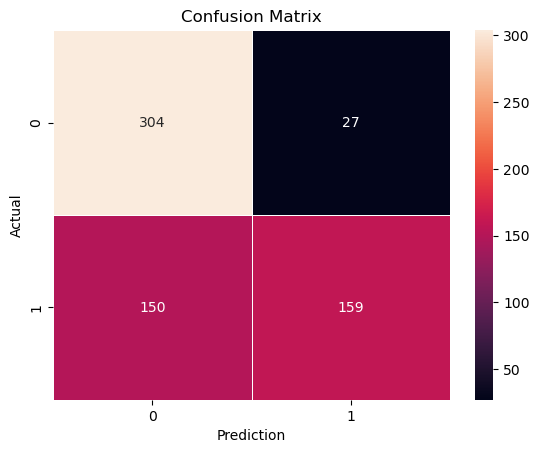

In [37]:
#plot confusion matrix
plt.figure()
cm = confusion_matrix(list_numeric_val, predictions_t1)
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.5)
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

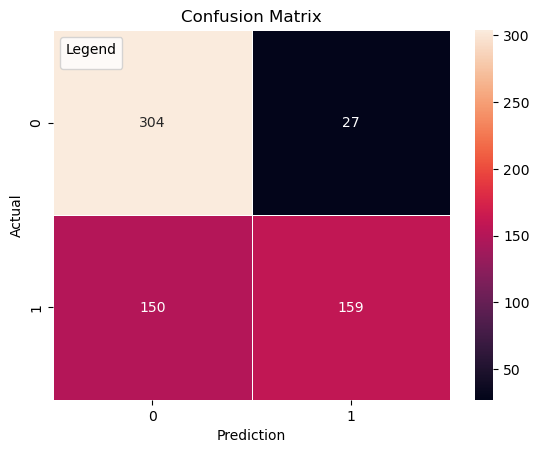

In [49]:
# Plot confusion matrix
plt.figure()
cm = confusion_matrix(list_numeric_val, predictions_t1)
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.5)
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')

# Add a legend
plt.legend(title="Legend", loc="upper left", labels=['not_propaganda','propaganda' ])

plt.show()

In [53]:
model_first_task.bert.save_pretrained("Task1_BERT_model")

In [238]:
model_try_first = BertModel.from_pretrained("Task1_BERT_model")

# Task2: Propaganda Classification

At first, copying dataframe can be better, otherwise it is required to work all codes from very beginning in case of making mistake

In [31]:
train_df3=train_df.copy(deep=True) #copy training dataframe
val_df3=val_df.copy(deep=True) #copy validation dataframe

Since the propaganda types are needed to be classified, not propaganda labelled rows must be excluded from the dataset

## Excluding not_propaganda from Dataframe

In [32]:
train_df3=train_df3[train_df3['label']!='not_propaganda']
val_df3=val_df3[val_df3['label']!='not_propaganda']

## Taking the Snippets

In [33]:
#function which gives the text between specified characters
def snippet(text,first_tag,second_tag):
    starting=text.find(first_tag)
    ending=text.find(second_tag)
    return text[starting+6:ending-1]

In [34]:
#changing sentence column with the records of snippets
train_df3['sentence']=train_df3['sentence'].apply(lambda x: snippet(x,"<BOS>","<EOS>"))
val_df3['sentence']=val_df3['sentence'].apply(lambda x: snippet(x,"<BOS>","<EOS>"))

In [35]:
#to check changes
train_df3.head()

,label,sentence
2,flag_waving,American people
5,loaded_language,annihilated
8,doubt,so-called evidence
10,"name_calling,labeling",hateful conduct
12,appeal_to_fear_prejudice,point to Iran’s positioning itself for more ag...


In [36]:
#finding labels and reverse version of it
labels={}
reverse={}
for i,j in enumerate(train_df3.label.unique()):
    labels[j]=i
    reverse_index[i]=j
labels

{'flag_waving': 0,
 'loaded_language': 1,
 'doubt': 2,
 'name_calling,labeling': 3,
 'appeal_to_fear_prejudice': 4,
 'repetition': 5,
 'causal_oversimplification': 6,
 'exaggeration,minimisation': 7}

In [37]:
reverse_index

{0: 'flag_waving',
 1: 'loaded_language',
 2: 'doubt',
 3: 'name_calling,labeling',
 4: 'appeal_to_fear_prejudice',
 5: 'repetition',
 6: 'causal_oversimplification',
 7: 'exaggeration,minimisation'}

**Good Approaches:**

- not to freeze model weights

- to increase epoch

- learning rate: $6.5x10^{-6}$


The good approaches have already been found in the task 1, according to that one, I changed the parameters to be sure that I get a good model

### not freeze model weights, epochs: 3, learning rate: $6.5x10^{-6}$

In [40]:
epochs=[3]
learning_rates= [1e-6, 6.5e-6]
batch_sizes=[2]

text_column_name='sentence'
bert_model=bertModel(par="base")

num_classes=len(labels.keys())
tokenizer=BertTokenizer.from_pretrained(bert_model)

In [41]:
train_data=Dataset(train_df3,text_column_name)
val_data=Dataset(val_df3,text_column_name)
list_numeric_train=list(train_df3['label'].apply(lambda x: labels[x]))
list_numeric_val=list(val_df3['label'].apply(lambda x: labels[x]))

In [42]:
results21=[]
for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for epoch in epochs:

            model=BertClassifier(num_classes=num_classes)

            result21,train_pred21,val_pred21=train(model,train_data,val_data,list_numeric_val,learning_rate,epoch,batch_size)
            print(result21)
            for i in result21:
                results21.append(i)

100%|████████████████████████████████████████████████████████████████████████████████| 646/646 [01:15<00:00,  8.51it/s]


[{'epochs': 3, 'train_loss': 1.0532088202159595, 'train_accuracy': 0.12470952749806352, 'val_loss': 1.0351894449647576, 'val_accuracy': 0.1423948220064725, 'time': 81.81351089477539, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 3, 'train_loss': 1.0348803985035762, 'train_accuracy': 0.17041053446940357, 'val_loss': 1.0128100242429567, 'val_accuracy': 0.26537216828478966, 'time': 163.49351286888123, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}, {'epochs': 3, 'train_loss': 1.0084743448046176, 'train_accuracy': 0.21533694810224632, 'val_loss': 0.9826978051546708, 'val_accuracy': 0.3106796116504854, 'time': 244.75003790855408, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 1e-06}]


100%|████████████████████████████████████████████████████████████████████████████████| 646/646 [01:15<00:00,  8.54it/s]


[{'epochs': 3, 'train_loss': 1.0125367707009467, 'train_accuracy': 0.20061967467079783, 'val_loss': 0.9283963059916079, 'val_accuracy': 0.3333333333333333, 'time': 81.3772964477539, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 6.5e-06}, {'epochs': 3, 'train_loss': 0.8865660689396049, 'train_accuracy': 0.3516653756777692, 'val_loss': 0.7982007899716448, 'val_accuracy': 0.4336569579288026, 'time': 163.03536415100098, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 6.5e-06}, {'epochs': 3, 'train_loss': 0.7151455301632722, 'train_accuracy': 0.5274980635166537, 'val_loss': 0.6683757434385108, 'val_accuracy': 0.5566343042071198, 'time': 243.96747994422913, 'batch_size': 2, 'Bert Model': 'bert-base-uncased', 'learning rate': 6.5e-06}]


As it can be seen above, it works better with the learning rate of $6.5x10^{-6}$.

### Finding the Best Epoch Number

- **model:** BERT base

- **epochs:** 10

- **learning rate:** $6.5x10^{-6}$

- **batch size:** 2

In [56]:
text_column_name='sentence'
bert_model=bertModel(par="base")

num_classes=len(labels.keys())
tokenizer=BertTokenizer.from_pretrained(bert_model)

In [57]:
train_data=Dataset(train_df3,text_column_name)
val_data=Dataset(val_df3,text_column_name)
list_numeric_train=list(train_df3['label'].apply(lambda x: labels[x]))
list_numeric_val=list(val_df3['label'].apply(lambda x: labels[x]))

In [58]:
model_second_task=BertClassifier(num_classes=num_classes)

In [59]:
result_final,train_pred_final,val_pred_final=train(model_second_task,
                                                   train_data,
                                                   val_data,
                                                   list_numeric_val,
                                                   learning_rate=6.5e-6,
                                                   epochs=10, 
                                                   batch_size=2)

100%|████████████████████████████████████████████████████████████████████████████████| 646/646 [01:16<00:00,  8.48it/s]


In [126]:
df = pd.DataFrame(result_final)
df

,epochs,train_loss,train_accuracy,val_loss,val_accuracy,time,batch_size,Bert Model,learning rate
0,10,1.021339,0.194423,0.966035,0.336570,81.195166,2,bert-base-uncased,0.000006
1,10,0.888856,0.382649,0.783630,0.485437,162.182614,2,bert-base-uncased,0.000006
2,10,0.641465,0.596437,0.640327,0.559871,243.513885,2,bert-base-uncased,0.000006
3,10,0.443986,0.759101,0.549515,0.647249,324.727251,2,bert-base-uncased,0.000006
4,10,0.288865,0.861348,0.572207,0.624595,405.901068,2,bert-base-uncased,0.000006
5,10,0.194085,0.914020,0.590816,0.644013,487.133564,2,bert-base-uncased,0.000006
6,10,0.127625,0.946553,0.623154,0.631068,568.249972,2,bert-base-uncased,0.000006
7,10,0.088712,0.965918,0.655357,0.640777,649.635240,2,bert-base-uncased,0.000006
8,10,0.067241,0.972889,0.697703,0.621359,731.609267,2,bert-base-uncased,0.000006
9,10,0.059235,0.972889,0.738718,0.595469,813.199158,2,bert-base-uncased,0.000006


It can be seen that the validation accuracy goes down after 8th epoch. There might be overfitting after that point. Because of that, I limited the epoch number at 8.

## The Final Model for the Second Task

In [127]:
text_column_name='sentence'
bert_model=bertModel(par="base")

num_classes=len(labels.keys())
tokenizer=BertTokenizer.from_pretrained(bert_model)

In [181]:
train_data=Dataset(train_df3,text_column_name)
val_data=Dataset(val_df3,text_column_name)
list_numeric_train=list(train_df3['label'].apply(lambda x: labels[x]))
list_numeric_val=list(val_df3['label'].apply(lambda x: labels[x]))

In [40]:
model_second_task=BertClassifier(num_classes=num_classes)

In [41]:
result_final,train_pred_final,val_pred_final=train(model_second_task,
                                                   train_data,
                                                   val_data,
                                                   list_numeric_val,
                                                   learning_rate=6.5e-6,
                                                   epochs=15, 
                                                   batch_size=2)

100%|████████████████████████████████████████████████████████████████████████████████| 646/646 [03:52<00:00,  2.78it/s]


In [42]:
df = pd.DataFrame(result_final)
df

,epochs,train_loss,train_accuracy,val_loss,val_accuracy,time,batch_size,Bert Model,learning rate
0,15,1.020870,0.192874,0.942842,0.291262,249.607533,2,bert-base-uncased,0.000006
1,15,0.866279,0.386522,0.766524,0.482201,500.819741,2,bert-base-uncased,0.000006
2,15,0.663429,0.580945,0.632216,0.576052,752.038532,2,bert-base-uncased,0.000006
3,15,0.470664,0.739737,0.557613,0.618123,1003.227200,2,bert-base-uncased,0.000006
4,15,0.308950,0.848954,0.591008,0.627832,1254.206833,2,bert-base-uncased,0.000006
5,15,0.202038,0.908598,0.580146,0.637540,1504.950478,2,bert-base-uncased,0.000006
6,15,0.131563,0.946553,0.623926,0.634304,1756.070040,2,bert-base-uncased,0.000006
7,15,0.092297,0.956623,0.620971,0.650485,2007.451801,2,bert-base-uncased,0.000006
8,15,0.075282,0.965143,0.688540,0.621359,2258.901383,2,bert-base-uncased,0.000006
9,15,0.053923,0.977537,0.701518,0.660194,2510.350192,2,bert-base-uncased,0.000006


After 6th step, validation loss got increase. I took epoch as 6.

## Evaluation Second Task

In [191]:
model_try = BertModel.from_pretrained("Task2_BERT_model")

In [43]:
results_t2,predictions_t2=evaluate(model_second_task,
               train_data,
               val_data,
               list_numeric_val,
               learning_rate=6.5e-6,
               epochs=6, 
               batch_size=2)

100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [00:18<00:00,  8.30it/s]


In [44]:
#classification report
report = classification_report(list_numeric_val, predictions_t2, zero_division=0, output_dict=True)

#convert it into dataframe
df_report_train2 = pd.DataFrame(report).transpose()
print("Model Performance")
df_report_train2

Model Performance


,precision,recall,f1-score,support
0,0.777778,0.622222,0.691358,45.00000
1,0.581395,0.641026,0.609756,39.00000
2,0.694444,0.581395,0.632911,43.00000
3,0.785714,0.647059,0.709677,34.00000
4,0.627907,0.627907,0.627907,43.00000
5,0.615385,0.600000,0.607595,40.00000
6,0.526316,0.857143,0.652174,35.00000
7,0.592593,0.533333,0.561404,30.00000
accuracy,0.637540,0.637540,0.637540,0.63754
macro avg,0.650191,0.638761,0.636598,309.00000


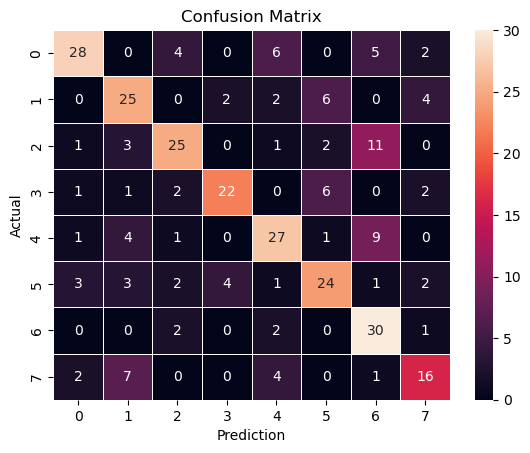

In [45]:
#plot confusion matrix
plt.figure()
cm = confusion_matrix(list_numeric_val, predictions_t2)
sns.heatmap(cm, annot=True, fmt="d", linewidths=0.5)
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [51]:
model_second_task.bert.save_pretrained("Task2_BERT_model")

NameError: name 'model_second_task' is not defined

All of the codes were taken from the laboratory notebooks (creating model) and added some extra ones.